# MeerKAT Uptime Calculations from Outlogs

This notebook was built to take a series of log text files for the MeerKAT array and determine how much time the array actively spends making observations using python. The primary objective is to help inform SETI commensal observation plans. This gives us a rough sense of how much time commensal observations can expect to obtain, assuming the outlogs are somewhat representative of how the array will be used going forward. The idea is to diagnose past use to inform future projections.

#### Section 1: Loading
To begin, I imported the necessary packages, a few custom functions, loaded the data files and parsed out the relevant text strings from each line of each file. 

#### Section 2: Tabulating and Filtering
I then built a dataframe table containing the relevant information on each observation. I filtered the dataframe table down based on the description of the scripts being run for each observation, and appended some additional information about each observation not directly listed in the outlogs but inferred from the timestamps.

#### Section 3: Probing the Data
With the pared down and neatly packaged table containing mostly only science objectives at this point I could draw some information from the data. This is where the uptime numbers are calculated. Scroll down to this section for the bottom line.

#### Section 4: Plotting
Everyone appreciates visual representations of the data. In this section I put together a few plots to display the uptime and number of observations by date and by weekday. 

#### Section 5: Further Refinement for BLUSE
This last section is an addendum, paring down the data even more to focus on pool resources relevant to bluse and seeing how that compares to some of the results above.

## Section 1: Loading

In [1]:
import os
import glob
import time
import pandas as pd
import numpy as np
from math import trunc
from datetime import datetime
from datetime import date
from datetime import timedelta

This next line finds the text files. Note that this assumes all the text files are within the same folder as the jupyter notebook.

In [2]:
outlogs=sorted(glob.glob('monitor.err.*'))

This next cell contains some custom functions for moving between a datetime object and the date/time strings as formatted in the text files.

In [3]:
# date and time string to a datetime object
def timestr_to_datetime(duration):
    return datetime.strptime(duration,'%H:%M:%S.%f')

def datetime_to_timestr(duration):
    return duration.strftime('%H:%M:%S.%f')

def dtdate_to_datestr(duration):
    return duration.strftime('%Y-%m-%d')

def dtstr_to_datetime(date_and_time):
    return datetime.strptime(date_and_time,'%Y-%m-%d %H:%M:%S.%f')

def datestr_to_datetime(date):
    return datetime.strptime(date,'%Y-%m-%d')

def timestr_to_secs(item):
    secs = float(item.split(':')[0])*3600+float(item.split(':')[1])*60+float(item.split(':')[2].replace(',','.'))
    return secs

def datetime_to_secs(item):
    return timestr_to_secs(datetime_to_timestr(item))

def secs_to_timestr(secs):
    h = trunc(secs/3600)
    m = trunc(secs/60-60*h)
    s = secs-3600*h-60*m
    return '%02d:%02d:%.6f' % (h, m, s)

This next cell is the main loop that harvests the log files for the relevant text strings. Here is a sample text block from the outlog file:

[ 2020-10-08 06:21:11,676 - INFO]  *subarray_1: Completed:* 
 ``` script_description: LADUMA season1 track L05
 pool_resources: cbf_1,fbfuse_1,sdp_1,tuse_1 and 58 antennas
 active_sbs: 20201002-0007
 script_name: /usr/local/bin/astrokat-observe.py
 script_status: completed
 Duration: 9:05:05.007441```

The loop reads each line of the file and triggers when the line contains "1: Completed:*" in order to both avoid double counting each subarray and to ensure we are looking at a completed observation block. Many erroneous outputs are time stamped, so we want to avoid counting those. 

Once the loop identifies a valid observation block it records the following from the block: 

The date and time of completion from this first line<br>
The script description<br>
The pool resources<br>
The number of antennas in use<br>
The script status (completed or interrupted)<br>
The duration of the observation

In [4]:
Duration_str=[]
EndDate_str=[]
End_Datetime_str=[]
EndTime_str=[]
WeekDay=[]
Script_str=[]
Status_str=[]
Pool_str=[]
Ants=[]
for num,file in enumerate(outlogs):
    searchfile = open(file,'r').readlines()
    for ell,line in enumerate(searchfile):
        if "1: Completed:*" in line:
            EndDate_str.append(line.split('INFO')[0][2:-3][:-13])
            EndTime_str.append(line.split('INFO')[0][2:-3][11:].replace(',','.'))
            End_Datetime_str.append(EndDate_str[-1]+" "+EndTime_str[-1])
            i=0
            sc=0
            st=0
            p=0
            while i<8 and (ell+i)<=(len(searchfile)-1):
                if 'Duration' in searchfile[ell+i]:
                    Duration_str.append(searchfile[ell+i][11:-4])
                    WeekDay.append(dtstr_to_datetime(End_Datetime_str[-1]).strftime('%A'))
                if 'script_description:' in searchfile[ell+i-1]:
                    Script_str.append(searchfile[ell+i-1].split("description:")[1][1:-1])
                    sc=1
                elif sc==0 and ((ell+i)==(len(searchfile)-1) or i==7):
                    Script_str.append('NO SCRIPT DESCRIPTION')                
                if 'script_status:' in searchfile[ell+i-1]:
                    Status_str.append(searchfile[ell+i-1].split(": ")[1][:-1])
                    st=1
                elif st==0 and ((ell+i)==(len(searchfile)-1) or i==7):
                    Status_str.append('NO SCRIPT STATUS')            
                if 'pool_resources:' in searchfile[ell+i-2]:
                    Pool_str.append(searchfile[ell+i-2].split(": ")[1][:-17])
                    Ants.append(searchfile[ell+i-2].split(": ")[1][-12:-10])
                    p=1
                elif p==0 and ((ell+i)==(len(searchfile)-2) or i==7):
                    Pool_str.append('NO POOL INFO')
                    Ants.append('UNKNOWN ANTS')
                i+=1

## Section 2: Tabulating and Filtering

For convenient data manipulation, the following cell concatenates the arrays made of the strings into a single pandas dataframe. It then prints the first 16 rows for visual inspection. I chose 16 just to see a new date tick over in the data.

In [5]:
a = EndDate_str
b = EndTime_str
c = [timestr_to_secs(EndTime_str[i]) for i,j in enumerate(EndTime_str)]
d = Duration_str
e = [timestr_to_secs(Duration_str[i]) for i,j in enumerate(Duration_str)]
f = WeekDay
g = Script_str
h = Status_str
i = Pool_str
j = Ants
Data_set = np.c_[a,b,c,d,e,f,g,h,i,j]
df = pd.DataFrame(np.column_stack([a,b,c,d,e,f,g,h,i,j]), 
                        columns=['Dates', 'End_Time', 'End_Secs','Duration','Obs_Secs','Week_Day','Script','Status','Pool','Ants'])
df['End_Secs']=df['End_Secs'].astype(float)
df['Obs_Secs']=df['Obs_Secs'].astype(float)
df['Ants']=df['Ants'].astype(int)
df[:16]

,Dates,End_Time,End_Secs,Duration,Obs_Secs,Week_Day,Script,Status,Pool,Ants
0,2020-10-08,06:21:11.676,22871.676,9:05:05.007441,32705.007441,Thursday,LADUMA season1 track L05,completed,"cbf_1,fbfuse_1,sdp_1,tuse_1",58
1,2020-10-08,08:19:14.278,29954.278,1:53:07.989088,6787.989088,Thursday,LSB73-J1010/J1013/J1015,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",58
2,2020-10-08,09:35:55.490,34555.490,0:06:47.790677,407.790677,Thursday,Delaycal,completed,"cbf_1,sdp_1",54
3,2020-10-08,09:51:05.899,35465.899,0:13:09.019194,789.019194,Thursday,Phase up with flatten bandpass,completed,"cbf_1,sdp_1",54
4,2020-10-08,10:05:27.105,36327.105,0:10:27.202847,627.202847,Thursday,10 minute track on calibrator,completed,"cbf_1,sdp_1",54
5,2020-10-08,10:52:58.490,39178.490,0:18:36.006281,1116.006281,Thursday,pointing check on J0408-6545,completed,"cbf_1,sdp_1",54
6,2020-10-08,11:59:38.881,43178.881,0:05:19.996302,319.996302,Thursday,Delaycal,completed,"apsuse_1,cbf_1,fbfuse_1,ptuse_2,ptuse_3,sdp_1,...",58
7,2020-10-08,12:09:44.281,43784.281,0:08:34.197882,514.197882,Thursday,TRAPUM phase up with flatten bandpass,completed,"apsuse_1,cbf_1,fbfuse_1,ptuse_2,ptuse_3,sdp_1,...",58
8,2020-10-08,16:18:18.285,58698.285,4:02:03.996016,14523.996016,Thursday,TRAPUM Globular Clusters: NGC6652,completed,"apsuse_1,cbf_1,fbfuse_1,ptuse_2,ptuse_3,sdp_1,...",58
9,2020-10-08,16:47:49.286,60469.286,0:05:10.192682,310.192682,Thursday,Delaycal,completed,"cbf_1,fbfuse_1,ptuse_3,ptuse_4,sdp_1,tuse_1",58


A lot of these observations are just calibrations and various other engineering tests that aren't actually science operations. Some of these things can be filtered out using the script description. The following cell removes entire rows of observations from the dataframe table based on the matching description string. Additional keys can be appended easily with a light copy+paste and edit.

I probed the list of script descriptions using df['Script'] to print them out and looked through them by eye for some that appeared to be engineering tests and calibrations. It would be appropriate to take another look at this list with a trained eye and/or consider other details that we may want to filter out or keep. It is also worth noting that some completed observation blocks had no scripts listed and no script descriptions with which to discriminate.

The output of this cell shows that a lot has been culled from this list. Many of the tests, bad runs and calibrations quickly add up in terms of number of completed blocks, but are short in duration and aren't actual science observations that could be used for commensal observing. Some things likely slipped through the cracks, but hopefully the majority of completed obvservation blocks that aren't actual science have been removed through this process. 

In [6]:
print('Original table length:',len(df),'completed blocks')

df = df[~df['Script'].str.contains('Delaycal')]
df = df[~df['Script'].str.contains('Full-Stokes imaging of MeerKAT gain calibrators (L) LST ')]
df = df[~df['Script'].str.contains('hase up with flatten bandpass')]
df = df[~df['Script'].str.contains('calibrator')]
df = df[~df['Script'].str.contains('Fluxcal')]
df = df[~df['Script'].str.contains('pointing check')]
df = df[~df['Script'].str.contains('alibration')]
df = df[~df['Script'].str.contains('engineering test')]
df = df[~df['Script'].str.contains('Engineering Spectral Line Test')]
df = df[~df['Script'].str.contains('System Tests')]
df = df[~df['Script'].str.contains('Slew to target')]

# Undecided whether to include this discriminator because some of these interrupted observations are of substantial length.
#df2 = df1[~df1['Status'].str.contains('interrupted')]   

print('Culled table length:',len(df), 'observations')
df[:4]

Original table length: 2120 completed blocks
Culled table length: 879 observations


C:\Users\sirsp\.conda\envs\rstudio\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Dates,End_Time,End_Secs,Duration,Obs_Secs,Week_Day,Script,Status,Pool,Ants
0,2020-10-08,06:21:11.676,22871.676,9:05:05.007441,32705.007441,Thursday,LADUMA season1 track L05,completed,"cbf_1,fbfuse_1,sdp_1,tuse_1",58
1,2020-10-08,08:19:14.278,29954.278,1:53:07.989088,6787.989088,Thursday,LSB73-J1010/J1013/J1015,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",58
8,2020-10-08,16:18:18.285,58698.285,4:02:03.996016,14523.996016,Thursday,TRAPUM Globular Clusters: NGC6652,completed,"apsuse_1,cbf_1,fbfuse_1,ptuse_2,ptuse_3,sdp_1,...",58
11,2020-10-08,20:01:21.289,72081.289,3:03:07.202944,10987.202944,Thursday,Meertime Relbin Oct 2020 epoch 5,completed,"cbf_1,fbfuse_1,ptuse_3,ptuse_4,sdp_1,tuse_1",58


At this point it is worth noting that the date and timestamp of each observation listed is the conclusion of the observation and the duration extends back in time. Thus, we have some instances where the duration is longer than the time elapsed on the date of completion. Again, looking at the very first observation as an example:

[ 2020-10-08 06:21:11,676 - INFO]  *subarray_1: Completed:* 
 ``` script_description: LADUMA season1 track L05
 pool_resources: cbf_1,fbfuse_1,sdp_1,tuse_1 and 58 antennas
 active_sbs: 20201002-0007
 script_name: /usr/local/bin/astrokat-observe.py
 script_status: completed
 Duration: 9:05:05.007441```
 
The duration indicates that this observation actually started the day before and carried into this day. So the next cell corrects for this by determining the start date and time. 

It also splits the duration time when it spans two days and adds the duration time from the previous day to the previous observation. It is worth noting that this is technically an inaccurate record per observation as it adds duration times to some observations. However, I am only after the uptime per day and this "correction" is appended in a new column so that it preserves an accurate duration record for each observation. 

In [7]:
count=0
Start_Time=[]
Start_Date=[]
This_Day_Obs_Secs=[]
i=-1
for row in df.itertuples():
    i+=1
    Start_Date.append(row.Dates)
    This_Day_Obs_Secs.append(row.Obs_Secs)
    diff = timestr_to_secs(row.End_Time) - timestr_to_secs(row.Duration)
    Start_Time.append(secs_to_timestr(diff))
    if row.End_Secs < row.Obs_Secs:
        This_Day_Obs_Secs[-1] = row.End_Secs
        Start_Time[-1] = secs_to_timestr(diff + 86400)
        Start_Date[-1] = dtdate_to_datestr(datestr_to_datetime(row.Dates) - timedelta(days=1))
        if i > 0:
            This_Day_Obs_Secs[-2] += row.Obs_Secs - row.End_Secs 
        count += 1
df['Start_Time'] = Start_Time
df['Start_Date'] = Start_Date
df['This_Day_Obs_Secs'] = This_Day_Obs_Secs
df['This_Day_Obs_Secs'] = df['This_Day_Obs_Secs'].astype(float)
print('Number of observations crossing midnight:',count)
df[:5]

Number of observations crossing midnight: 103


,Dates,End_Time,End_Secs,Duration,Obs_Secs,Week_Day,Script,Status,Pool,Ants,Start_Time,Start_Date,This_Day_Obs_Secs
0,2020-10-08,06:21:11.676,22871.676,9:05:05.007441,32705.007441,Thursday,LADUMA season1 track L05,completed,"cbf_1,fbfuse_1,sdp_1,tuse_1",58,21:16:6.668559,2020-10-07,22871.676000
1,2020-10-08,08:19:14.278,29954.278,1:53:07.989088,6787.989088,Thursday,LSB73-J1010/J1013/J1015,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",58,06:26:6.288912,2020-10-08,6787.989088
8,2020-10-08,16:18:18.285,58698.285,4:02:03.996016,14523.996016,Thursday,TRAPUM Globular Clusters: NGC6652,completed,"apsuse_1,cbf_1,fbfuse_1,ptuse_2,ptuse_3,sdp_1,...",58,12:16:14.288984,2020-10-08,14523.996016
11,2020-10-08,20:01:21.289,72081.289,3:03:07.202944,10987.202944,Thursday,Meertime Relbin Oct 2020 epoch 5,completed,"cbf_1,fbfuse_1,ptuse_3,ptuse_4,sdp_1,tuse_1",58,16:58:14.086056,2020-10-08,21543.112914
15,2020-10-09,06:09:16.302,22156.302,9:05:12.211970,32712.211970,Friday,LADUMA season1 track L06,completed,"cbf_1,fbfuse_1,sdp_1,tuse_1",59,21:04:4.090030,2020-10-08,22156.302000


## Section 3: Probing the Data

This is where we get to the numbers that matter. This next cell has self-explanatory output. 

The "Ideal" observation duration is based on the current plan to obtain 5 minutes of observation for each target and a nominal 15 minutes to process that 5 minute observation. This can be adjusted once we have better constraints on our processing time.

In [8]:
# Set observation duration benchmark for long/short observations
Ideal = 20 # minutes

# Totals

Total_Observation_Time = df['This_Day_Obs_Secs'].sum()
Ave_Obs_Dur = df['Obs_Secs'].sum()/len(df)
Total_Log_Time = len(set(df['Dates']))*86400
Total_Uptime = Total_Observation_Time / Total_Log_Time
Num_Short_Obs = df.loc[df['Obs_Secs'] < Ideal*60].count()[0]
Num_Long_Obs = df.loc[df['Obs_Secs'] > Ideal*60].count()[0]
Ave_Num_Obs = len(df)/len(set(df['Dates']))
Ave_Obs_Hours = Ave_Num_Obs * Ave_Obs_Dur/3600
Max_Dur = df['Obs_Secs'].max()
Min_Dur = df['Obs_Secs'].min()
Ave_Ants = df['Ants'].sum()/len(df)
Max_Ants = df['Ants'].max()
Min_Ants = df['Ants'].min()
LessThanSec = len(df[df['Obs_Secs'] <1]['Obs_Secs'])
print(f'Total Observation Time: \t\t\t\t{Total_Observation_Time:.2f} seconds', 
      f'= {Total_Observation_Time/3600:.2f} hours = {Total_Observation_Time/86400:.2f} days.')
print(f'Total Operational Time: \t\t\t\t{Total_Log_Time:.2f} seconds', 
      f'= {Total_Log_Time/3600:.2f} hours = {int(Total_Log_Time/86400)} days.')
print(f'\nAverage Number of Antennas In Use: \t\t\t{Ave_Ants:.0f} antennas.')
print(f'Maximum Number of Antennas In Use: \t\t\t{Max_Ants:.0f} antennas.')
print(f'Minimum Number of Antennas In Use: \t\t\t{Min_Ants:.0f} antennas.')
print(f'\nAverage Observation Duration: \t\t\t\t{Ave_Obs_Dur/3600:.2f} hours.')
print(f'Longest Observation Duration: \t\t\t\t{Max_Dur/3600:.2f} hours.')
print(f'Shortest Observation Duration: \t\t\t\t{Min_Dur} seconds.')
print(f'\t\t\t\t\t\t\t[There were {LessThanSec} "Observations" Less Than 1 second.]')
print(f'\nAverage Observations per Day: \t\t\t\t{Ave_Num_Obs:.0f}')
print(f'Average Observation Hours per Day: \t\t\t{Ave_Obs_Hours:.2f} hours.')
print(f'\nNumber of Observations Less Than {Ideal} minutes: \t\t{Num_Short_Obs} = {Num_Short_Obs/len(df)*100:.2f}%')
print(f'Number of Observations Longer Than {Ideal} minutes: \t\t{Num_Long_Obs} = {Num_Long_Obs/len(df)*100:.2f}%')
print(f'\nTotal Uptime: \t\t\t\t\t\t{Total_Uptime*100:.2f}%')

Total Observation Time: 				7015245.88 seconds = 1948.68 hours = 81.19 days.
Total Operational Time: 				10886400.00 seconds = 3024.00 hours = 126 days.

Average Number of Antennas In Use: 			56 antennas.
Maximum Number of Antennas In Use: 			64 antennas.
Minimum Number of Antennas In Use: 			4 antennas.

Average Observation Duration: 				2.22 hours.
Longest Observation Duration: 				17.57 hours.
Shortest Observation Duration: 				0.000224 seconds.
							[There were 11 "Observations" Less Than 1 second.]

Average Observations per Day: 				7
Average Observation Hours per Day: 			15.49 hours.

Number of Observations Less Than 20 minutes: 		334 = 38.00%
Number of Observations Longer Than 20 minutes: 		545 = 62.00%

Total Uptime: 						64.44%


The previous cell tells us some interesting things as an overview, but we can take a closer look at some of the more interesting things that didn't get filtered out to see if we want to add additional filters and reiterate the process.

For example, 17.57 hours as the maximum observation duration is a very long observation. The cell below shows the dataframe rows containing observations longer than 12 hours. The longest completed observation in this set of log files was taken on Christams Day 2020. The start and end times line up with the duration. There's no overlap with another day and the script description suggests this was a legitimate science observation. 

In [9]:
# Let's probe which observations took longer than 12 hours to complete.

df[df['Obs_Secs']>3600*12]

,Dates,End_Time,End_Secs,Duration,Obs_Secs,Week_Day,Script,Status,Pool,Ants,Start_Time,Start_Date,This_Day_Obs_Secs
1368,2020-12-25,21:20:26.972,76826.972,17:34:07.804980,63247.804980,Friday,Stonehenge L - visibility variance due to the Sun,completed,"cbf_1,fbfuse_1,sdp_1,tuse_1",62,03:46:19.167020,2020-12-25,63247.804980
1459,2020-12-31,20:18:39.495,73119.495,12:27:34.210867,44854.210867,Thursday,UHF Observation of the Giant X-shaped Radio Ga...,completed,"cbf_1,fbfuse_1,sdp_1,tuse_1",60,07:51:5.284133,2020-12-31,57390.515491
1461,2021-01-01,20:54:57.115,75297.115,17:01:14.371555,61274.371555,Friday,Stonehenge UHF - visibility variance due to th...,completed,"cbf_1,fbfuse_1,sdp_1,tuse_1",60,03:53:42.743445,2021-01-01,72008.454416


However, there are still many ultra short duration observations despite my best attempt to filter them out. Another iteration is likely needed. Printing out the dataframe rows for some of these ultra short observations in the cell below shows that many of these were run without script descriptions and/or were interrupted scripts. 

In [10]:
# Number of observations less than 1 second.

df[df['Obs_Secs'] <1]

,Dates,End_Time,End_Secs,Duration,Obs_Secs,Week_Day,Script,Status,Pool,Ants,Start_Time,Start_Date,This_Day_Obs_Secs
370,2020-10-31,01:26:44.767,5204.767,0:00:00.999739,0.999739,Saturday,MHONGOOSE J0419-54 setting 3,completed,"cbf_1,fbfuse_1,sdp_1,tuse_1",60,01:26:43.767261,2020-10-31,0.999739
743,2020-11-19,17:07:14.044,61634.044,0:00:00.000669,0.000669,Thursday,TRAPUM Globular Clusters: NGC6752 epoch 2,interrupted,"apsuse_1,cbf_1,fbfuse_1,ptuse_2,ptuse_3,ptuse_...",58,17:07:14.043331,2020-11-19,0.000669
1047,2020-12-05,03:52:49.240,13969.240,0:00:00.000350,0.000350,Saturday,NO SCRIPT DESCRIPTION,completed,"apsuse_1,cbf_1,fbfuse_1,sdp_1,tuse_1",61,03:52:49.239650,2020-12-05,0.000350
1076,2020-12-06,18:07:42.168,65262.168,0:00:00.000370,0.000370,Sunday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",60,18:07:42.167630,2020-12-06,0.000370
1077,2020-12-06,18:16:11.096,65771.096,0:00:00.000375,0.000375,Sunday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",60,18:16:11.095625,2020-12-06,0.000375
1078,2020-12-06,18:24:40.280,66280.280,0:00:00.000402,0.000402,Sunday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",60,18:24:40.279598,2020-12-06,0.000402
1103,2020-12-07,18:00:08.280,64808.280,0:00:00.000346,0.000346,Monday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",58,18:00:8.279654,2020-12-07,0.000346
1115,2020-12-08,15:13:15.864,54795.864,0:00:00.000307,0.000307,Tuesday,NO SCRIPT DESCRIPTION,completed,"cbf_1,fbfuse_1,ptuse_4,sdp_1,tuse_1",57,15:13:15.863693,2020-12-08,0.000307
1118,2020-12-08,16:22:13.081,58933.081,0:00:00.000401,0.000401,Tuesday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,ptuse_4,sdp_1,tuse_1",57,16:22:13.080599,2020-12-08,0.000401
1119,2020-12-08,16:30:42.264,59442.264,0:00:00.000320,0.000320,Tuesday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,ptuse_4,sdp_1,tuse_1",57,16:30:42.263680,2020-12-08,0.000320


Also, multiple parameters can be investigated at once across a dataframe to narrow down the list of interesting "observations" to take a closer look at. 

In [11]:
# Let's take a look at them...

df[(df['Status'] =='interrupted') & (df['Obs_Secs'] < 1) & (df['Script']=='NO SCRIPT DESCRIPTION')]

,Dates,End_Time,End_Secs,Duration,Obs_Secs,Week_Day,Script,Status,Pool,Ants,Start_Time,Start_Date,This_Day_Obs_Secs
1076,2020-12-06,18:07:42.168,65262.168,0:00:00.000370,0.000370,Sunday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",60,18:07:42.167630,2020-12-06,0.000370
1077,2020-12-06,18:16:11.096,65771.096,0:00:00.000375,0.000375,Sunday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",60,18:16:11.095625,2020-12-06,0.000375
1078,2020-12-06,18:24:40.280,66280.280,0:00:00.000402,0.000402,Sunday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",60,18:24:40.279598,2020-12-06,0.000402
1103,2020-12-07,18:00:08.280,64808.280,0:00:00.000346,0.000346,Monday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,sdp_1,tuse_1",58,18:00:8.279654,2020-12-07,0.000346
1118,2020-12-08,16:22:13.081,58933.081,0:00:00.000401,0.000401,Tuesday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,ptuse_4,sdp_1,tuse_1",57,16:22:13.080599,2020-12-08,0.000401
1119,2020-12-08,16:30:42.264,59442.264,0:00:00.000320,0.000320,Tuesday,NO SCRIPT DESCRIPTION,interrupted,"cbf_1,fbfuse_1,ptuse_4,sdp_1,tuse_1",57,16:30:42.263680,2020-12-08,0.000320


## Section 4: Plotting

In this section I put together four main plots:

The observations per weekday.<br>
The number of observations each day.<br>
The number of observational hours (i.e. the uptime) each day.<br>
The average number of antennas in use each day.

In each plot a Red-Yellow-Green color scheme is employed as a quick visual clue to see how each bar relates to the maximum/optimal value. 

This first cell calculates the number of observations done each weekday and arguably belongs in the above section, but its results are immediately plotted in the following cell.

In [12]:
# Number of observations per weekday
weekdays=[]
df = df.reset_index(drop=True)
for i,dt in enumerate(df['Dates']):
    weekdays.append(datestr_to_datetime(df['Dates'][i]).weekday())

week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y=[]
for i,key in enumerate(week):
    print(f'{weekdays.count(i)} observations taken on {key}.')
    y.append(weekdays.count(i))
print(sum(y),'total observations logged.')

154 observations taken on Monday.
125 observations taken on Tuesday.
108 observations taken on Wednesday.
143 observations taken on Thursday.
116 observations taken on Friday.
122 observations taken on Saturday.
111 observations taken on Sunday.
879 total observations logged.


#### Plot 1: By Weekday

The first plot made here is actually two subplots showing the average uptime for the array by weekday and the average number of observations each weekday. Total averages are overlaid with horizontal dashed lines. 

C:\Users\sirsp\.conda\envs\rstudio\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


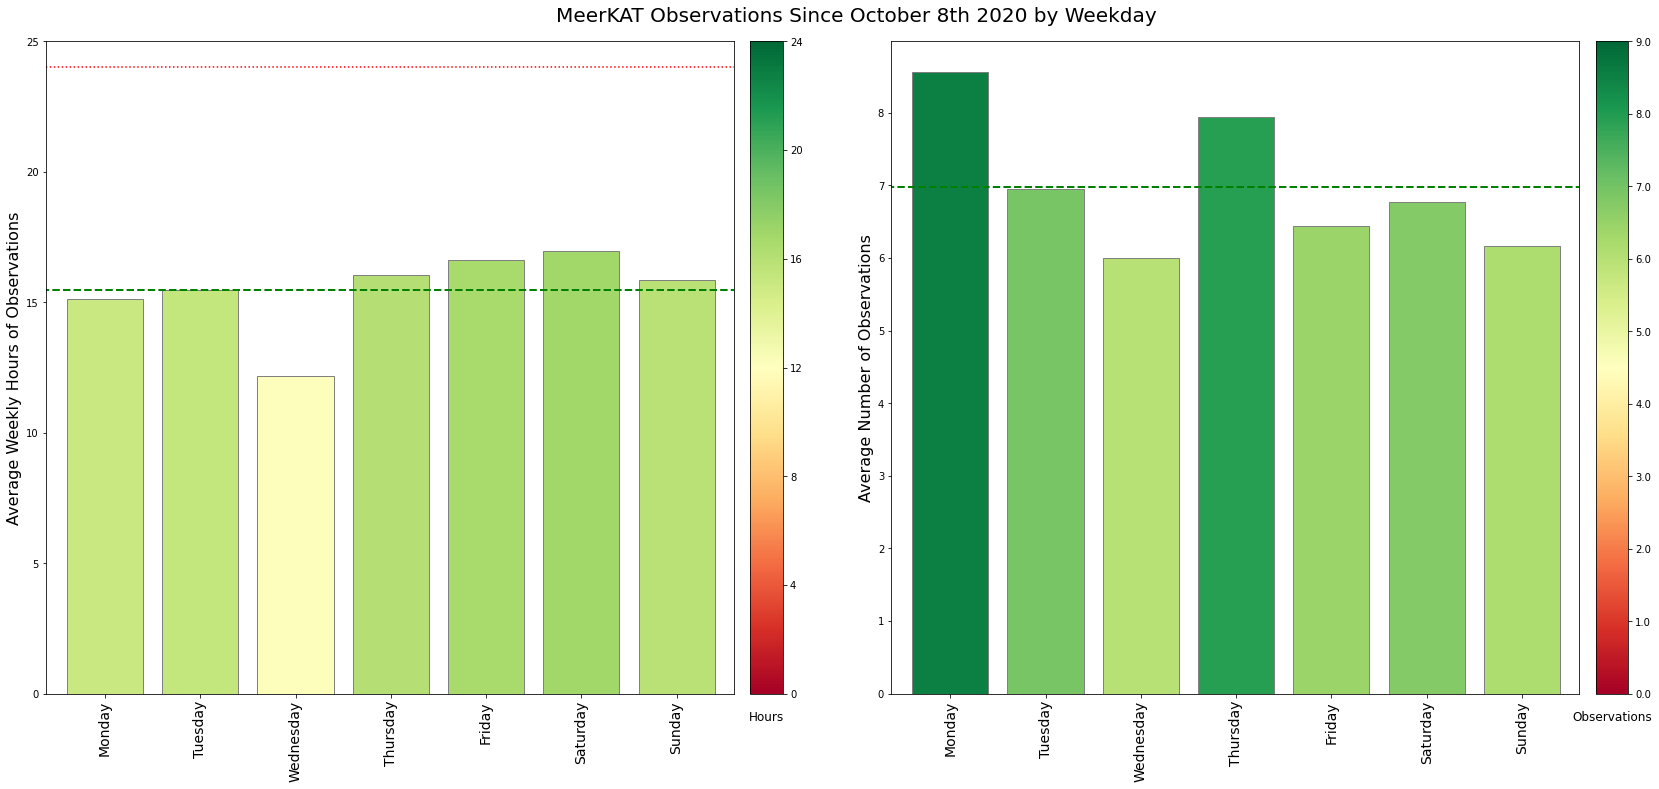

In [13]:
# Plot the number of observations for each weekday
import matplotlib
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(30,12))

# set the data to be plotted
Hours_per_WeekDay = (df.groupby(['Week_Day']).sum()['This_Day_Obs_Secs']*24/86400*7/126).reset_index()
for i in Hours_per_WeekDay.index:
    Hours_per_WeekDay.Week_Day[i]=(time.strptime(Hours_per_WeekDay.reset_index().Week_Day[i], "%A").tm_wday)
Hours_per_WeekDay=Hours_per_WeekDay.sort_values('Week_Day').reset_index(drop=True)
Hours_per_WeekDay['Week_Day']=week
Hours_per_WeekDay=Hours_per_WeekDay.set_index('Week_Day').squeeze()
y2 = [w/18 for w in y]                    # Each log file spans one week

# Set colormapping for each subplot
interval0=4
interval1=1
hours=np.arange(0,24+interval0,interval0)
wobs=np.arange(0,max(y2)+interval1,interval1)
cmap = plt.cm.RdYlGn
norm0 = matplotlib.colors.Normalize(vmin=min(hours), vmax=max(hours))
norm1 = matplotlib.colors.Normalize(vmin=min(wobs), vmax=max(wobs))
colors0=cmap(norm0(Hours_per_WeekDay))
colors1=cmap(norm1(y2))
pad=0.02
sm0 = plt.cm.ScalarMappable(cmap=cmap, norm=norm0)
cbar0=fig.colorbar(sm0, ax=ax[0],pad=pad)
cbar0.set_ticks(hours)
cbar0.set_ticklabels(hours)
cbar0.ax.set_title('Hours',y=-0.05)
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm1)
cbar1=fig.colorbar(sm1, ax=ax[1],pad=pad)
cbar1.set_ticks(wobs)
cbar1.set_ticklabels(wobs)
cbar1.ax.set_title('Observations',y=-0.05)
fig.subplots_adjust(wspace=0.02)

# Make the bar plots
ax[0].bar(week,Hours_per_WeekDay,edgecolor='grey',color=colors0)
ax[1].bar(week,y2,edgecolor='grey',color=colors1)

# Overlay the max hours in a day and average hours of observation per day
ax[0].hlines(y=24,xmin=-1,xmax=7,color='red',linestyle='dotted')
ax[0].hlines(y=Ave_Obs_Hours,xmin=-1,xmax=7,color='green',linestyle='dashed',linewidth=2)

# Overlay the second plot with the average number of observations per day
ax[1].hlines(y=Ave_Num_Obs,xmin=-1,xmax=7,color='green',linestyle='dashed',linewidth=2)

# set limits and make it pretty
ax[0].set_ylim(0,25)
ax[0].set_xlim(-0.62,6.6)
ax[1].set_xlim(-0.62,6.6)
ax[0].set_xticks(week)
ax[1].set_xticks(week)
ax[0].set_xticklabels(week,rotation='90',fontsize=14)
ax[1].set_xticklabels(week,rotation='90',fontsize=14)
ax[0].set_ylabel('Average Weekly Hours of Observations', fontsize=16)
ax[1].set_ylabel('Average Number of Observations', fontsize=16)
fig.suptitle('MeerKAT Observations Since October 8th 2020 by Weekday', fontsize=20, y=0.92)
plt.show()

#### Plot 2: Observations each day

This second plot simply tallies the number of observations each day that are 5 minutes in duration or longer and plots them in a bar graph. On its own this plot doesn't actually tell us much, but the color scale shows us something somewhat interesting. 

Each bar is colored using a Red-Yellow-Green scale normalized to the uptime per day, where the most green is the closest to 24 hours of operation. In this way you can visually cross-reference the number of observations per day with how many hours the array was actually doing science. 

Clearly, the number of observations does not necessarily correspond to the amount of uptime. We wouldn't necessarily expect this. But this could be helpful to inform our commensal strategy with a rough idea of how many different pointings we may be able to expect each day. 

The total average number of observations each day (including those less than five minutes) from the culled dataframe is plotted as a horizontal dashed line.

Because of the daily accumulation of data over a long timescale, this plot is best viewed in a separate window to make it bigger.

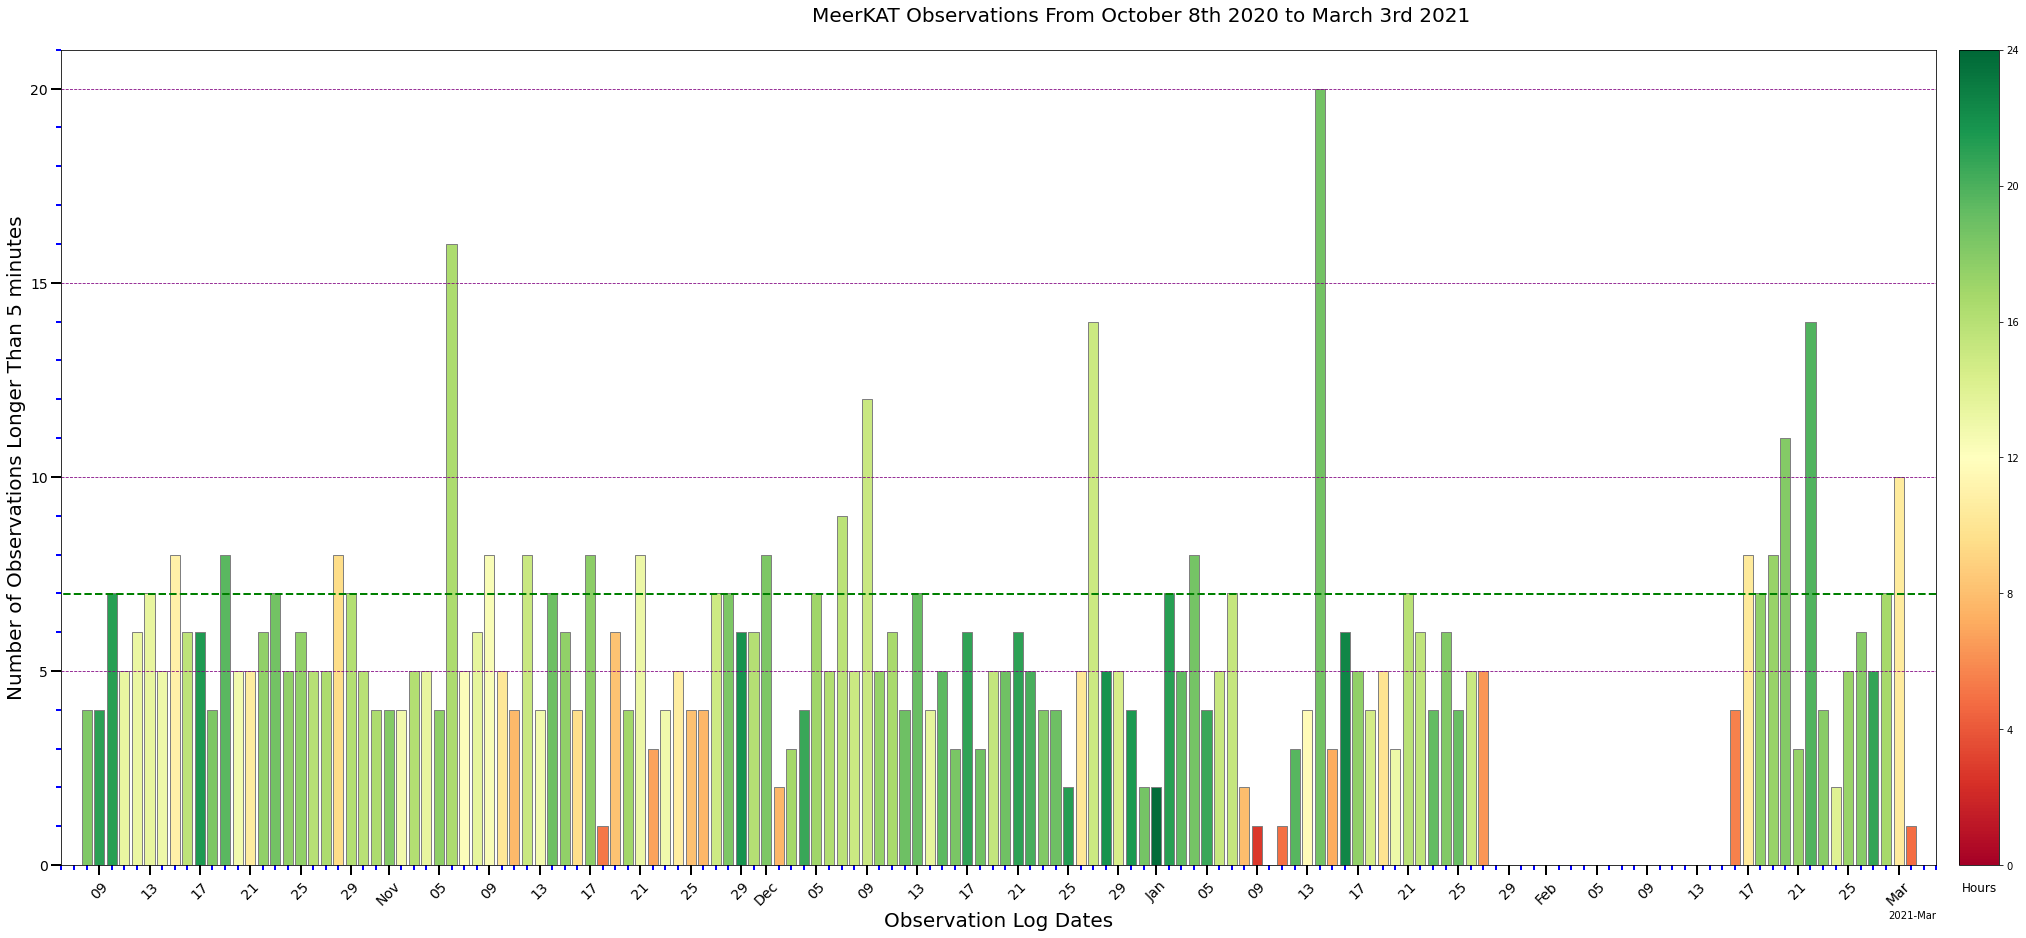

In [14]:
# Plot the number of observations taken each day over the log period.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(40,15))

# Set data to be plotted
Dates=[]
for row in df.itertuples():
    Dates.append(pd.to_datetime(row.Dates).date())   # Get the dates in a plot-friendly format
Dates = sorted(list(set(Dates)))
Upbydate = df.groupby('Dates').sum()['This_Day_Obs_Secs'].divide(3600) # Total time of observations per day in seconds
num_obs = df[df['Obs_Secs']>=300]['Dates'].value_counts().sort_index()         # number of observations each day

# Set colormapping
interval = 4
hours = np.arange(0,24+interval,interval)
cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=min(hours), vmax=max(hours))
colors=cmap(norm(Upbydate))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar=fig.colorbar(sm,pad=0.01)
cbar.set_ticks(hours)
cbar.set_ticklabels(hours)
cbar.ax.set_title('Hours',y=-0.04)

# Make the bar plot, overlaid with the average number of observations
plt.bar(Dates, num_obs,edgecolor='grey',color=colors)
plt.hlines(y=Ave_Num_Obs,xmin=18531,xmax=18692,color='green',linestyle='dashed',linewidth=2)

# matplotlib date plotting axis stuff
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
locator = mdates.AutoDateLocator(minticks=6, maxticks=40)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)

# make it pretty
plt.xticks(rotation='45',size=14)
plt.yticks(size=14)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5, color='blue')
plt.grid(axis='y', which='major', color='purple', linestyle='--')
ax.set_xlim(18541,18690)
ax.set_ylim(0,int(max(num_obs))+1)

# set axis labels and title
plt.xlabel('Observation Log Dates', fontsize=20)
plt.ylabel('Number of Observations Longer Than 5 minutes', fontsize=20)
fig.suptitle('MeerKAT Observations From October 8th 2020 to March 3rd 2021', fontsize=20, y=0.92)
plt.show()

#### Plot 3: Uptime each day

This is likely the most interesting plot. It shows the number of hours per day that the array is doing actual science based on the culled dataframe. The Red-Yellow_Green color scheme gives a quick visual clue about how close the array is to conducting science observations for the full 24 hours each day, where red is on the low end and green on the high end. 

Again, because of the daily accumulation of data over a long timescale, this plot is best viewed in a separate window to make it bigger.

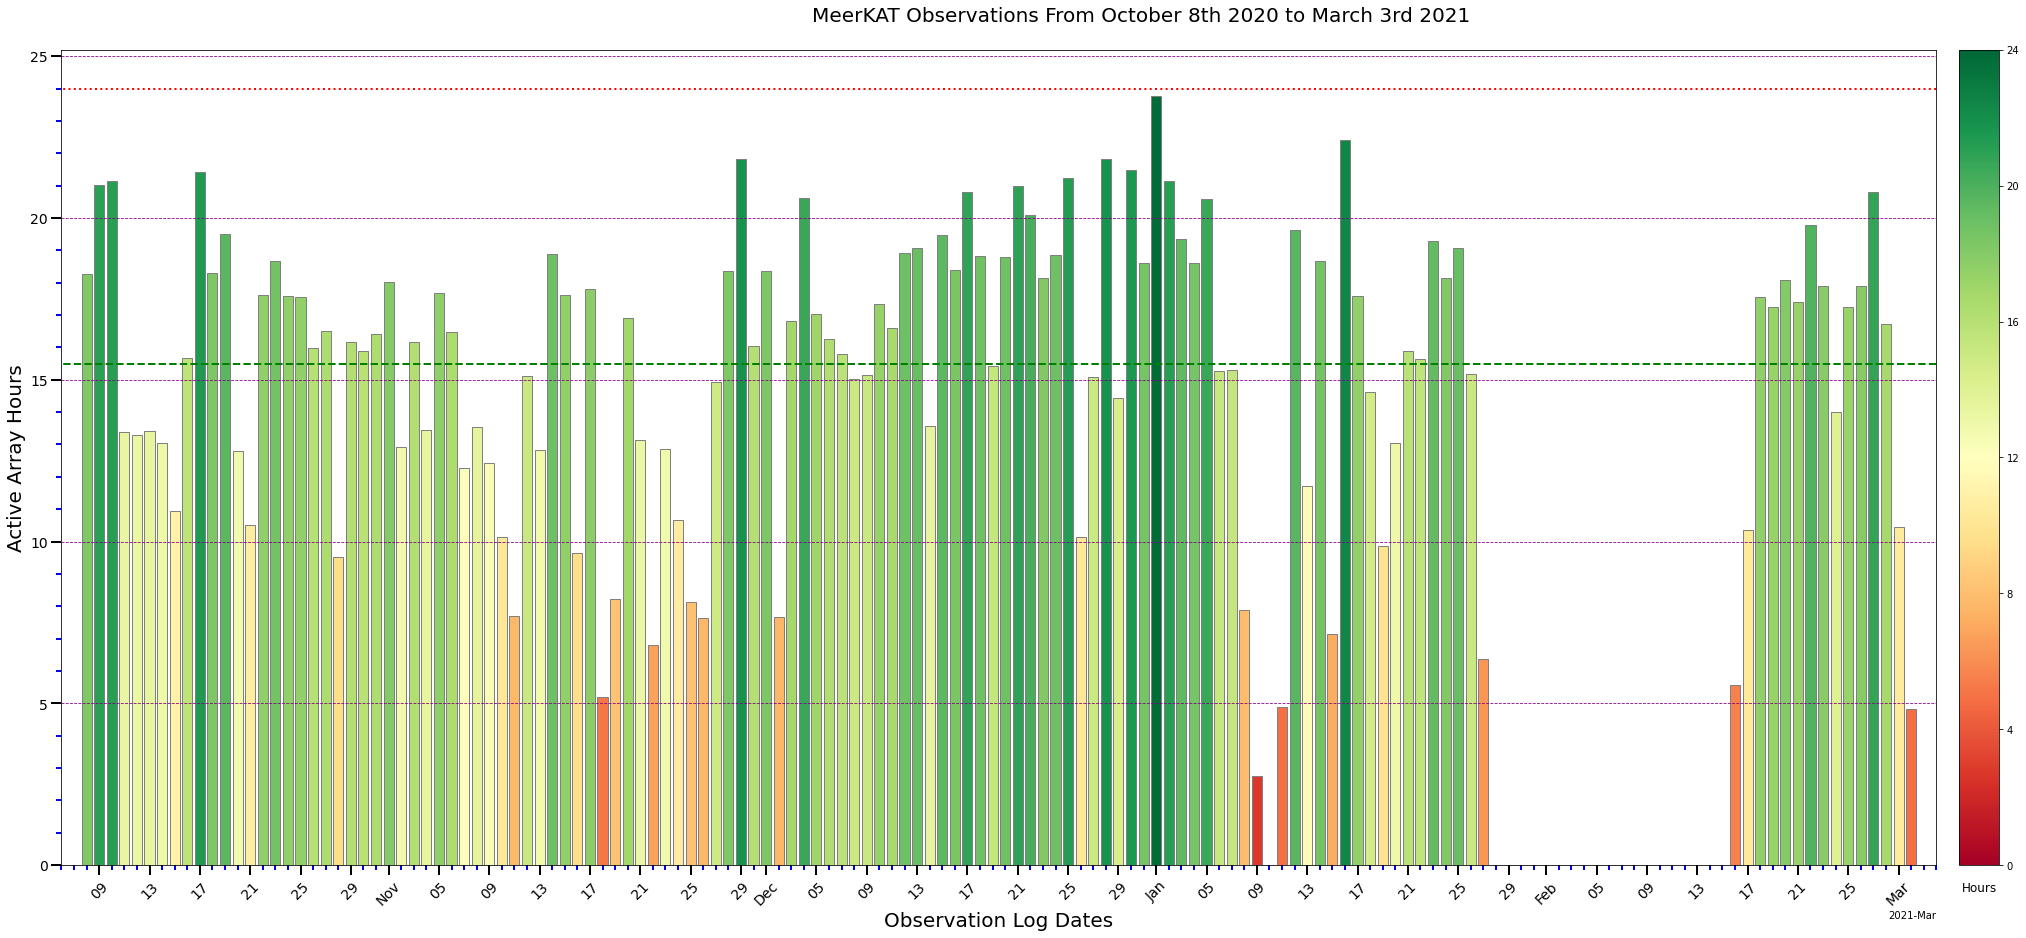

In [15]:
# Plot the number of observations taken each day over the log period.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(40,15))

# Set data to be plotted
Dates=[]
for row in df.itertuples():
    Dates.append(pd.to_datetime(row.Dates).date())   # Get the dates in a plot-friendly format
Dates = sorted(list(set(Dates)))
Upbydate = df.groupby('Dates').sum()['This_Day_Obs_Secs'].divide(3600) # Total time of observations per day in seconds

# Set colormapping
interval = 4
hours = np.arange(0,24+interval,interval)
cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=min(hours), vmax=max(hours))
colors=cmap(norm(Upbydate))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar=fig.colorbar(sm,pad=0.01)
cbar.set_ticks(hours)
cbar.set_ticklabels(hours)
cbar.ax.set_title('Hours',y=-0.04)

# Make the bar plot, overlaid with max hours and average observation hours lines
plt.bar(Dates, Upbydate,edgecolor='grey',color=colors)
plt.hlines(y=24,xmin=18531,xmax=18692,color='red',linestyle='dotted',linewidth=2)
plt.hlines(y=Ave_Obs_Hours,xmin=18531,xmax=18692,color='green',linestyle='dashed',linewidth=2)

# matplotlib date plotting axis stuff
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
locator = mdates.AutoDateLocator(minticks=6, maxticks=40)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)

# make it pretty
plt.xticks(rotation='45',size=14)
plt.yticks(size=14)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5, color='blue')
plt.grid(axis='y', which='major', color='purple', linestyle='--')
ax.set_xlim(18541,18690)

# set axis labels and title
plt.xlabel('Observation Log Dates', fontsize=20)
plt.ylabel('Active Array Hours', fontsize=20)
fig.suptitle('MeerKAT Observations From October 8th 2020 to March 3rd 2021', fontsize=20, y=0.92)
plt.show()

#### Plot 4: Working Antennas

This last plot was made to show how many of the 64 antennas in the array are actually active each day. To plot this by day this required averaging the number of antennas up for each observation that day. 

The total average over all the observations in the culled dataframe is plotted as a dashed green line. And the Red-Yellow_Green scale again shows how close the array is maximum capacity that day.

Additionally overlaid are "error" bars showing the minimum and maximum number of antennas used for an observation that day. This shows that on some days some observations were carried out with a low number of antennas, but most observations were operating near full capacity so the average is weighted more heavily toward the higher end. 

Again, because of the daily accumulation of data over a long timescale, this plot is best viewed in a separate window to make it bigger.

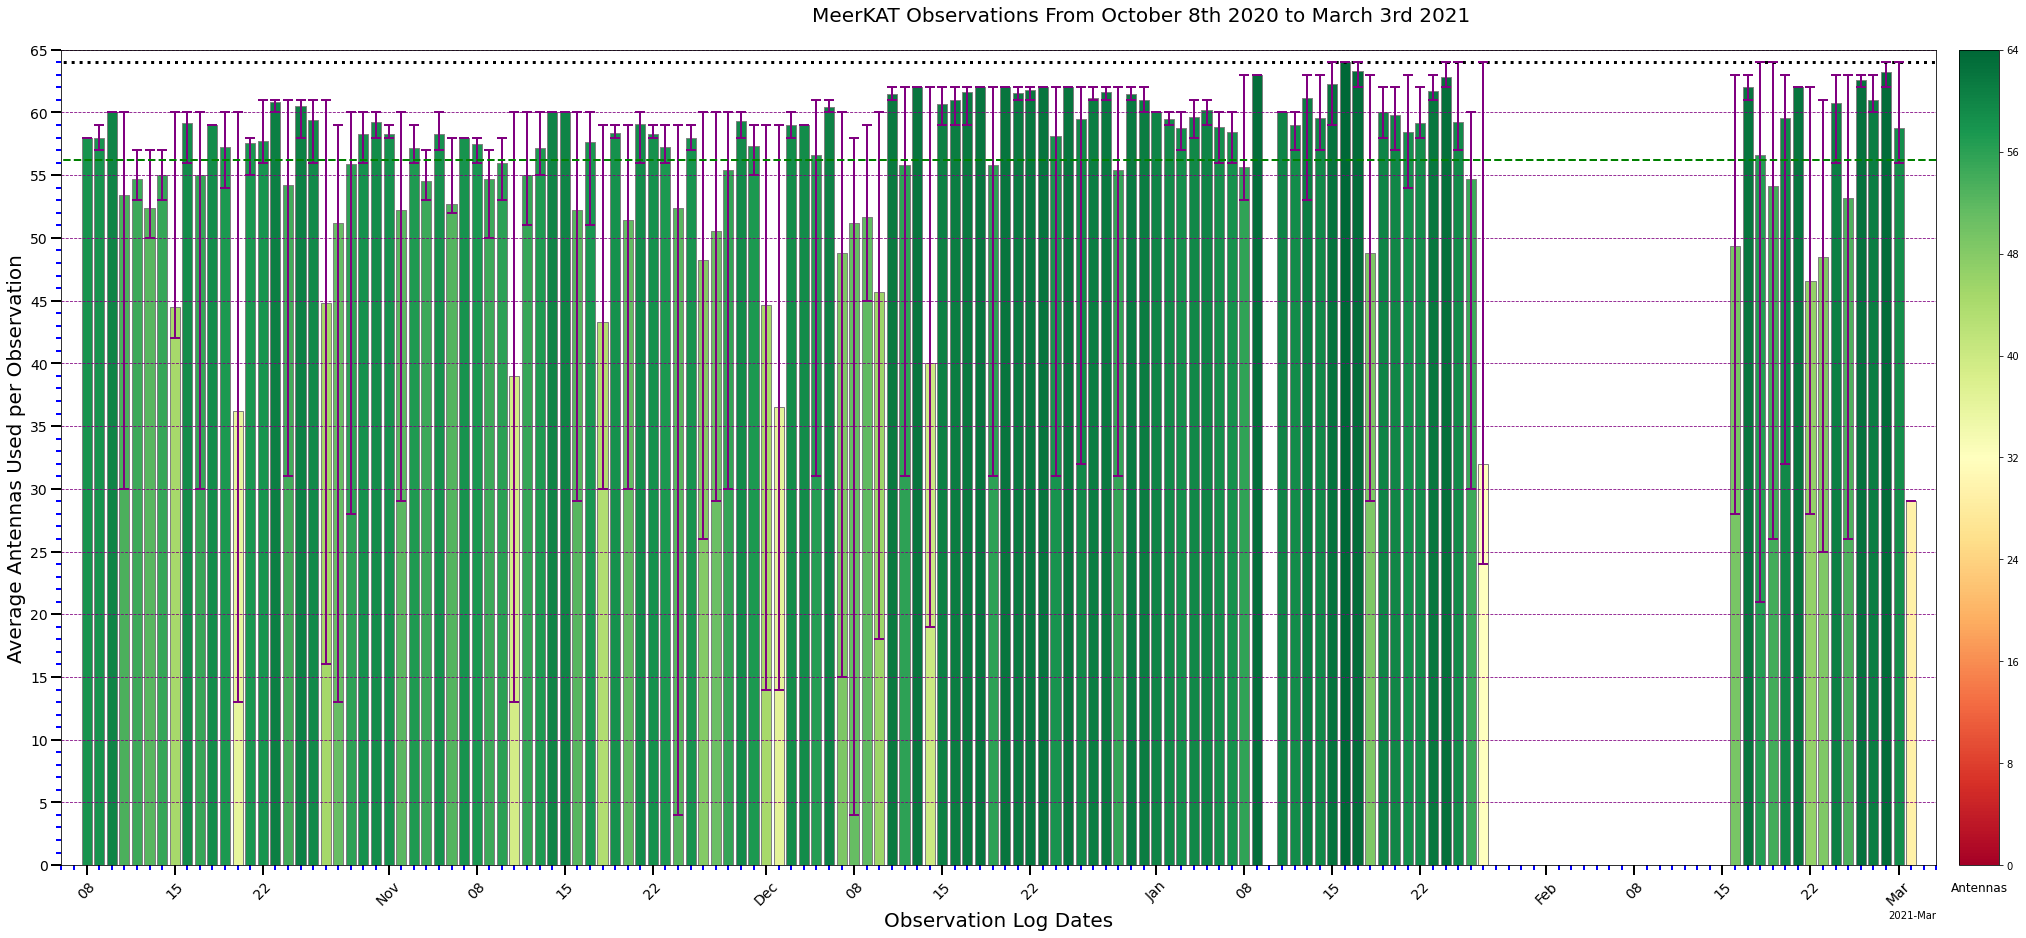

In [16]:
# Plot the number of antennas in use each day over the log period.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(40,15))

# Set data to be plotted
Dates=[]
for row in df.itertuples():
    Dates.append(pd.to_datetime(row.Dates).date())   # Get the dates in a plot-friendly format
Dates = sorted(list(set(Dates)))
num_obs = df['Dates'].value_counts().sort_index() 
ave_ant_per_day = df.groupby('Dates').sum()['Ants']/num_obs         # number of observations each day

# Get the min/max antennas used to be plotted as an "error" bar
err = [df.groupby(['Dates'])['Ants'].mean() - df.groupby(['Dates'])['Ants'].min(),
       df.groupby(['Dates'])['Ants'].max() - df.groupby(['Dates'])['Ants'].mean()]
err[0].index = [datestr_to_datetime(x).date() for x in err[0].index]
err[1].index = [datestr_to_datetime(x).date() for x in err[1].index]
Ant_err_min = [x for x in err[0]]
Ant_err_max = [x for x in err[1]]
Ant_err = [np.array(Ant_err_min),np.array(Ant_err_max)]

# Set colormapping
interval=8
ants=np.arange(0,64+interval,interval)
cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=min(ants), vmax=max(ants))
colors=cmap(norm(ave_ant_per_day))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar=fig.colorbar(sm,pad=0.01)
cbar.set_ticks(ants)
cbar.set_ticklabels(ants)
cbar.ax.set_title('Antennas',y=-0.04)

# Make the bar plot, overlaid with average and max antenna lines
plt.bar(Dates, ave_ant_per_day,color=colors,edgecolor='grey',yerr=Ant_err,error_kw=dict(ecolor='purple', lw=2, capsize=5, capthick=2))
plt.hlines(y=64,xmin=18531,xmax=18692,color='black',linestyle='dotted',linewidth=3)
plt.hlines(y=Ave_Ants,xmin=18531,xmax=18692,color='green',linestyle='dashed',linewidth=2)

# matplotlib date plotting axis stuff
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
locator = mdates.AutoDateLocator(minticks=6, maxticks=30)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)

# make it pretty
plt.xticks(rotation='45',size=14)
plt.yticks(size=14)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5, color='blue')
plt.grid(axis='y', which='major', color='purple', linestyle='--')
ax.set_xlim(18541,18690)
ax.set_ylim(0,65)

# set axis labels and title
plt.xlabel('Observation Log Dates', fontsize=20)
plt.ylabel('Average Antennas Used per Observation', fontsize=20)
fig.suptitle('MeerKAT Observations From October 8th 2020 to March 3rd 2021', fontsize=20, y=0.92)
plt.show()

## Section 5: Further Refinement for BLUSE

This section takes another look at paring down the data. 

First, the unique script descriptions are listed out so that a more trained eye can look through them and identify non-science objectives to be eliminated. 

While awaiting further guidance on the script description I turned my attention to the pool tags and examined the blocks tagged for bluse. I am not sure if this is comprehensive or accurate. It may miss some observations that went untagged. As can be seen in the plots, it eliminates a substantial portion of earlier observations.

Ostensibly, bluse should be included on all science observations for commensal observing. However, it is my understanding that not all science teams were on board with this until recently. This may partially explain why some of the bluse-only observations are less than the total.   

To start, the following cell displays a list of all the remaining unique script descriptions so that we can look and see what else should be removed.

In [17]:
print(len(set(df['Script'])),'unique scripts in the culled dataframe.')
print('\nThe remaining script descriptions in the culled dataframe are as follows:')
sorted(set(df['Script']))

494 unique scripts in the culled dataframe.

The remaining script descriptions in the culled dataframe are as follows:


['',
 ' 2: S-band holography scan-extent 3 scanspeed 0.05 cycle-duration 5400 tracktime 20 m000',
 ' L-band holography tracktime 5 elevation histogram',
 ' UHF-band holography --scan-extent 15 --tracktime 5 --cycle-duration 2700 elevation-histogram',
 '1: S-band holography high-end (3062.5MHz) scan-extent 4 scanspeed 0.05 cycle-duration 3600 tracktime 10',
 '1: S-band holography low-end (2187.5MHz) scan-extent 6 scanspeed 0.075 cycle-duration 3600 tracktime 10',
 '1: S-band-mid holography (2625 MHz) scan-extent 5 scanspeed 0.0625 cycle-duration 3600 tracktime 10',
 '2021csp epoch1',
 'AT2019azh nov 2020',
 'Antlia Cluster in HIgh def',
 'Antlia Cluster in HIgh def (2)',
 'Antlia Cluster in HIgh def (3)',
 'Antlia Cluster in HIgh def (4)',
 'Antlia Cluster in HIgh def (5)',
 'Antlia Cluster in HIgh def (6)',
 'Antlia Cluster in HIgh def (8)',
 'BLUSE/APSUSE - track on Vela',
 'Basic RFI Scan: RFI horizon scan',
 'COM-20191129-MG-01 UHF 1K TAB coherency',
 'COM-20191129-MG-01 UHF 1K TAB 

Each observation block is also tagged with a pool list, presumably identifying who has access to the data being collected. This next cell identifies all the unique names used in the pool.

In [18]:
Pool_list=[]
len(df['Pool'][i].split(','))
for i in range(len(df)):
    for n,item in enumerate(df.Pool[i].split(',')):
        if not df['Pool'][i].split(',')[n] in Pool_list:
            Pool_list.append(df['Pool'][i].split(',')[n])
print('The list of unique users in the pool:')
sorted(Pool_list)

The list of unique users in the pool:


['apsuse_1',
 'bluse_1',
 'cbf_1',
 'cbf_dev_1',
 'fbfuse_1',
 'ptuse_1',
 'ptuse_2',
 'ptuse_3',
 'ptuse_4',
 'sdp_',
 'sdp_1',
 'tuse_1']

As this is a BLUSE project, let's look at just those observations that list BLUSE in the pool. Note that a new dataframe is created here so that we can compare it to the culled dataframe from earlier. 

In [19]:
df2 = df[df['Pool'].str.contains('bluse')].reset_index(drop=True)
df2

,Dates,End_Time,End_Secs,Duration,Obs_Secs,Week_Day,Script,Status,Pool,Ants,Start_Time,Start_Date,This_Day_Obs_Secs
0,2020-10-21,17:10:46.759,61846.759,0:03:50.192421,230.192421,Wednesday,"['J1939-6342', 'J1939-6342_offset'] integratio...",completed,"bluse_1,cbf_1,fbfuse_1,sdp_1,tuse_1",58,17:06:56.566579,2020-10-21,230.192421
1,2020-10-21,17:27:13.159,62833.159,0:08:56.595254,536.595254,Wednesday,['GPS_1520'] integration observation,interrupted,"bluse_1,cbf_1,fbfuse_1,sdp_1,tuse_1",58,17:18:16.563746,2020-10-21,536.595254
2,2020-10-21,17:32:12.158,63132.158,0:03:24.596737,204.596737,Wednesday,['GPS_1525'] integration observation,interrupted,"bluse_1,cbf_1,fbfuse_1,sdp_1,tuse_1",58,17:28:47.561263,2020-10-21,204.596737
3,2020-12-21,20:38:54.299,74334.299,0:04:51.798821,291.798821,Monday,NO SCRIPT DESCRIPTION,completed,"bluse_1,cbf_1,fbfuse_1,sdp_1,tuse_1",62,20:34:2.500179,2020-12-21,291.798821
4,2020-12-21,21:02:16.093,75736.093,0:04:53.002946,293.002946,Monday,NO SCRIPT DESCRIPTION,completed,"bluse_1,cbf_1,fbfuse_1,sdp_1,tuse_1",62,20:57:23.090054,2020-12-21,293.002946
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,2021-02-28,19:13:15.553,69195.553,0:09:43.800414,583.800414,Sunday,NO SCRIPT DESCRIPTION,completed,"bluse_1,cbf_1,sdp_1",64,19:03:31.752586,2021-02-28,583.800414
215,2021-02-28,23:11:48.558,83508.558,3:06:32.004231,11192.004231,Sunday,Antlia Cluster in HIgh def (8),completed,"bluse_1,cbf_1,sdp_1",64,20:05:16.553769,2021-02-28,11192.004231
216,2021-02-28,23:49:50.756,85790.756,0:04:49.997421,289.997421,Sunday,NO SCRIPT DESCRIPTION,completed,"bluse_1,cbf_1,sdp_1",64,23:45:0.758579,2021-02-28,513.238788
217,2021-03-01,07:28:58.164,26938.164,7:32:41.405367,27161.405367,Monday,GroupS2,completed,"bluse_1,cbf_1,sdp_1",64,23:56:16.758633,2021-02-28,26938.164000


#### Plots and Data Analysis

Now let's recreate the Uptime plot with the bluse pool data with the old uptime plot faded out in the background to give us a visual sense of the difference.

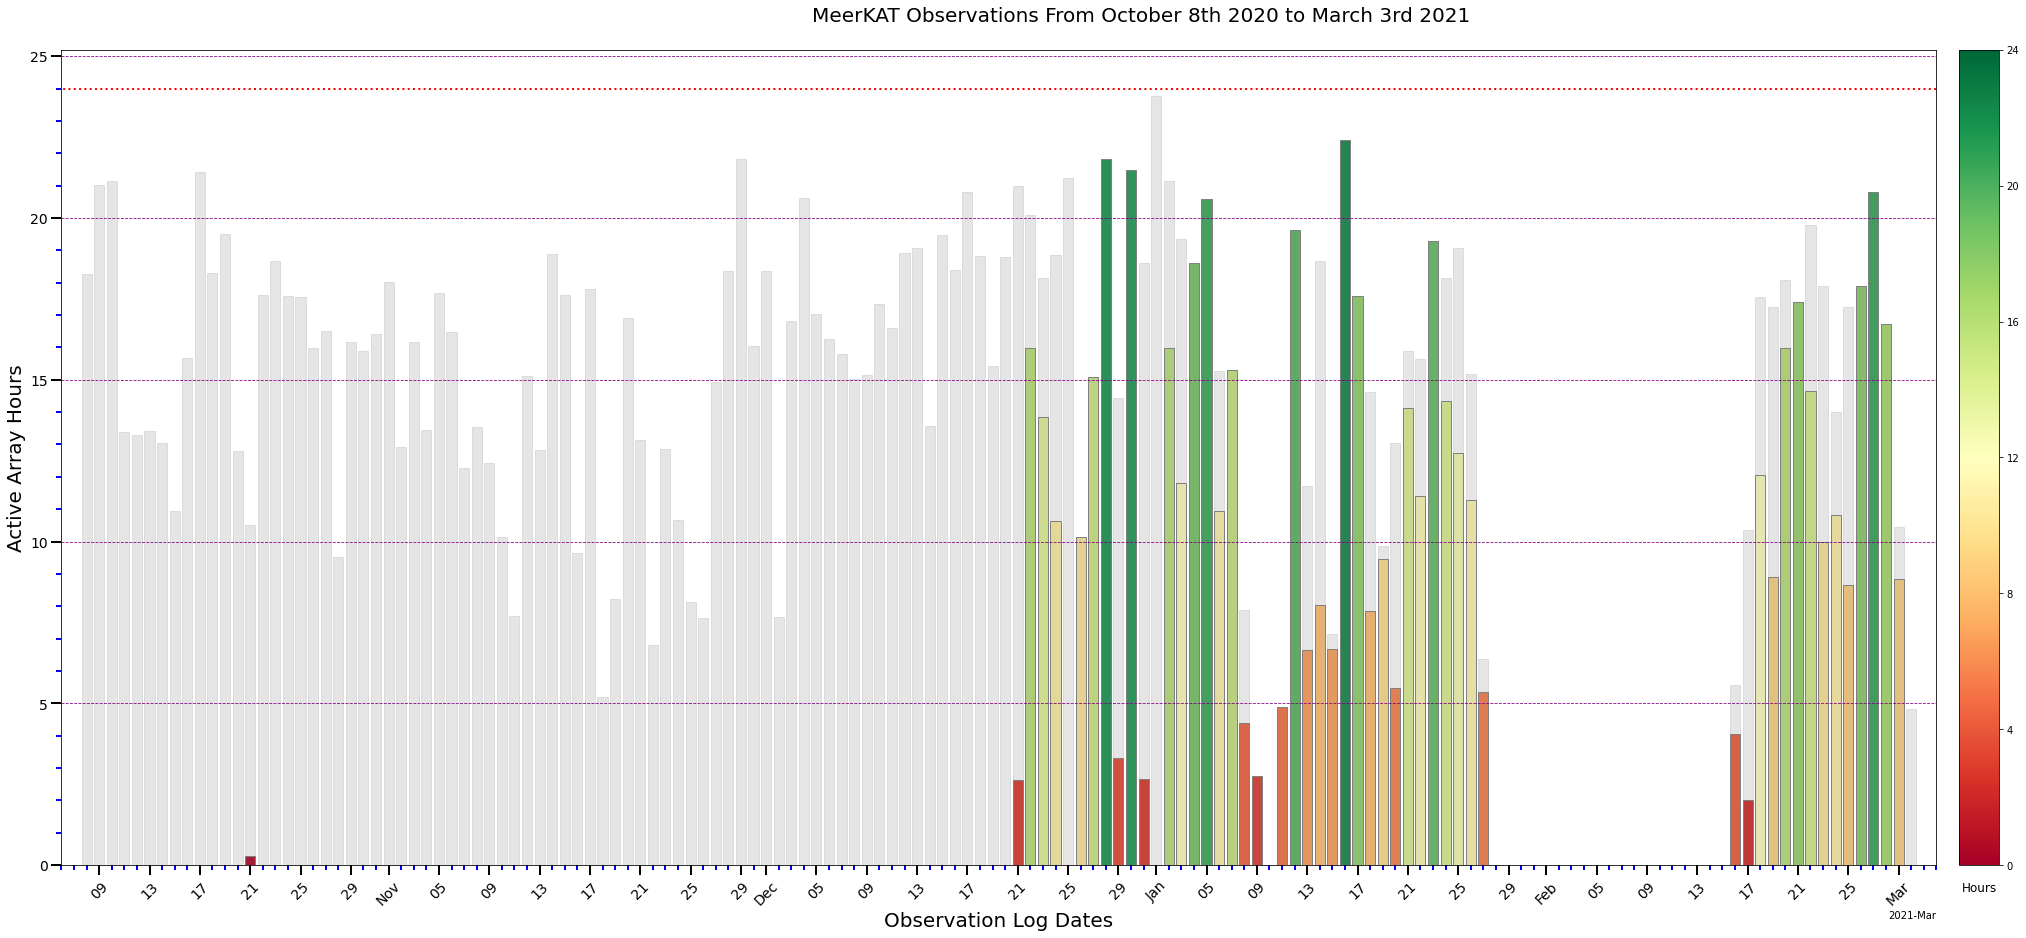

In [20]:
# Plot the number of observations taken each day over the log period.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(40,15))

# Set data to be plotted
Dates2=[]
for row in df2.itertuples():
    Dates2.append(pd.to_datetime(row.Dates).date())   # Get the dates in a plot-friendly format
Dates2 = sorted(list(set(Dates2)))
Upbydate2 = df2.groupby('Dates').sum()['This_Day_Obs_Secs'].divide(3600) # Total time of observations per day in seconds

# Set colormapping
interval = 4
hours = np.arange(0,24+interval,interval)
cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=min(hours), vmax=max(hours))
colors=cmap(norm(Upbydate2))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar=fig.colorbar(sm,pad=0.01)
cbar.set_ticks(hours)
cbar.set_ticklabels(hours)
cbar.ax.set_title('Hours',y=-0.04)

# Make the bar plot, overlaid with max hours and average observation hours lines
plt.bar(Dates2, Upbydate2,edgecolor='grey',color=colors)
plt.bar(Dates, Upbydate,edgecolor='grey',color='grey',alpha=0.2)
plt.hlines(y=24,xmin=18531,xmax=18692,color='red',linestyle='dotted',linewidth=2)
# plt.hlines(y=Ave_Obs_Hours,xmin=18531,xmax=18692,color='green',linestyle='dashed',linewidth=2)

# matplotlib date plotting axis stuff
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
locator = mdates.AutoDateLocator(minticks=6, maxticks=40)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)

# make it pretty
plt.xticks(rotation='45',size=14)
plt.yticks(size=14)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5, color='blue')
plt.grid(axis='y', which='major', color='purple', linestyle='--')
ax.set_xlim(18541,18690)

# set axis labels and title
plt.xlabel('Observation Log Dates', fontsize=20)
plt.ylabel('Active Array Hours', fontsize=20)
fig.suptitle('MeerKAT Observations From October 8th 2020 to March 3rd 2021', fontsize=20, y=0.92)
plt.show()

Looking at just bluse tagged pool data, let's get some numbers as we did before...

In [21]:
# Set observation duration benchmark for long/short observations
Ideal = 20 # minutes

# Totals

Total_Observation_Time2 = df2['This_Day_Obs_Secs'].sum()
Ave_Obs_Dur2 = df2['Obs_Secs'].sum()/len(df2)
Total_Log_Time2 = len(set(df2['Dates']))*86400
Total_Uptime2 = Total_Observation_Time2 / Total_Log_Time2
Num_Short_Obs2 = df2.loc[df2['Obs_Secs'] < Ideal*60].count()[0]
Num_Long_Obs2 = df2.loc[df2['Obs_Secs'] > Ideal*60].count()[0]
Ave_Num_Obs2 = len(df2)/len(set(df2['Dates']))
Ave_Obs_Hours2 = Ave_Num_Obs2 * Ave_Obs_Dur2/3600
Max_Dur2 = df2['Obs_Secs'].max()
Min_Dur2 = df2['Obs_Secs'].min()
Ave_Ants2 = df2['Ants'].sum()/len(df2)
Max_Ants2 = df2['Ants'].max()
Min_Ants2 = df2['Ants'].min()
LessThanSec2 = len(df2[df2['Obs_Secs'] <1]['Obs_Secs'])
print(f'Total Observation Time: \t\t\t\t{Total_Observation_Time2:.2f} seconds', 
      f'= {Total_Observation_Time2/3600:.2f} hours = {Total_Observation_Time2/86400:.2f} days.')
print(f'Total Operational Time: \t\t\t\t{Total_Log_Time2:.2f} seconds', 
      f'= {Total_Log_Time2/3600:.2f} hours = {int(Total_Log_Time2/86400)} days.')
print(f'\nAverage Number of Antennas In Use: \t\t\t{Ave_Ants2:.0f} antennas.')
print(f'Maximum Number of Antennas In Use: \t\t\t{Max_Ants2:.0f} antennas.')
print(f'Minimum Number of Antennas In Use: \t\t\t{Min_Ants2:.0f} antennas.')
print(f'\nAverage Observation Duration: \t\t\t\t{Ave_Obs_Dur2/3600:.2f} hours.')
print(f'Longest Observation Duration: \t\t\t\t{Max_Dur2/3600:.2f} hours.')
print(f'Shortest Observation Duration: \t\t\t\t{Min_Dur2} seconds.')
print(f'\t\t\t\t\t\t\t[There were {LessThanSec2} "Observations" Less Than 1 second.]')
print(f'\nAverage Observations per Day: \t\t\t\t{Ave_Num_Obs2:.0f}')
print(f'Average Observation Hours per Day: \t\t\t{Ave_Obs_Hours2:.2f} hours.')
print(f'\nNumber of Observations Less Than {Ideal} minutes: \t\t{Num_Short_Obs2} = {Num_Short_Obs2/len(df2)*100:.2f}%')
print(f'Number of Observations Longer Than {Ideal} minutes: \t\t{Num_Long_Obs2} = {Num_Long_Obs2/len(df2)*100:.2f}%')
print(f'\nTotal Uptime: \t\t\t\t\t\t{Total_Uptime2*100:.2f}%')

Total Observation Time: 				2103493.60 seconds = 584.30 hours = 24.35 days.
Total Operational Time: 				4320000.00 seconds = 1200.00 hours = 50 days.

Average Number of Antennas In Use: 			61 antennas.
Maximum Number of Antennas In Use: 			64 antennas.
Minimum Number of Antennas In Use: 			56 antennas.

Average Observation Duration: 				2.69 hours.
Longest Observation Duration: 				8.63 hours.
Shortest Observation Duration: 				2.000634 seconds.
							[There were 0 "Observations" Less Than 1 second.]

Average Observations per Day: 				4
Average Observation Hours per Day: 			11.77 hours.

Number of Observations Less Than 20 minutes: 		82 = 37.44%
Number of Observations Longer Than 20 minutes: 		137 = 62.56%

Total Uptime: 						48.69%


And just for fun, the antennas plot remade:

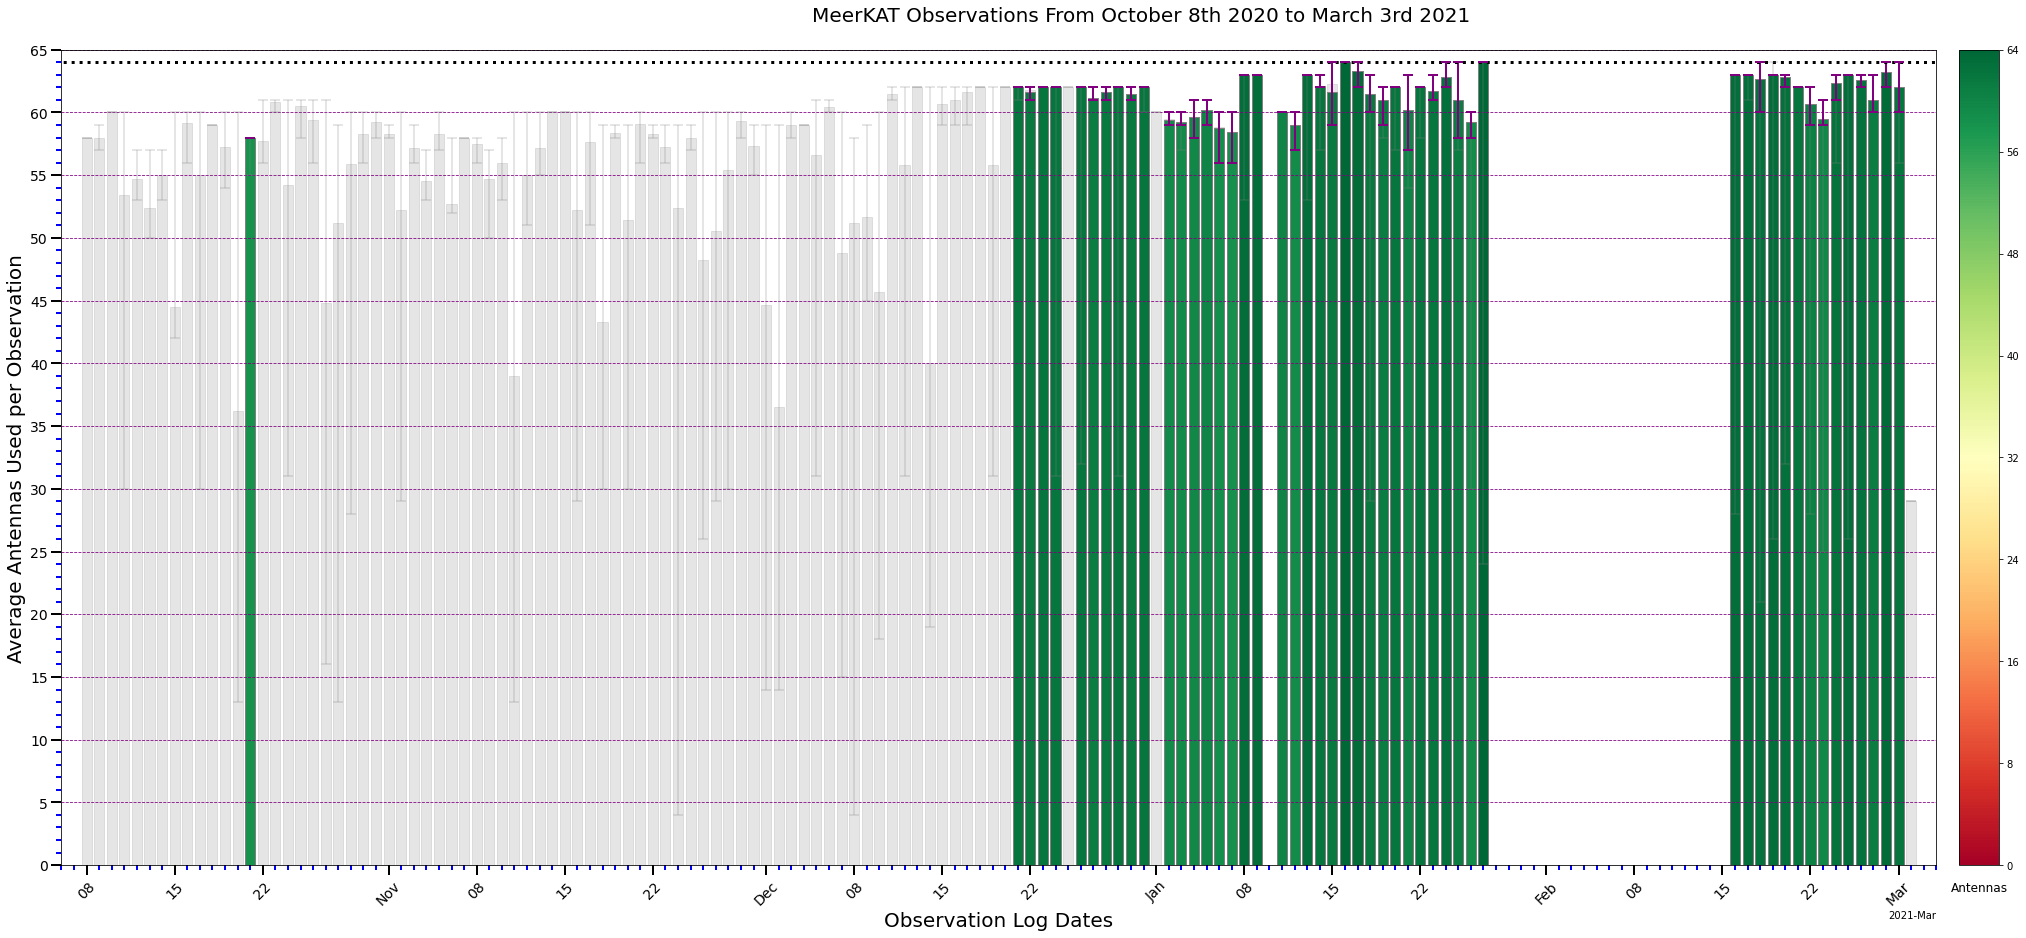

In [22]:
# Plot the number of antennas in use each day over the log period.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(40,15))

# Set data to be plotted
Dates2=[]
for row in df2.itertuples():
    Dates2.append(pd.to_datetime(row.Dates).date())   # Get the dates in a plot-friendly format
Dates2 = sorted(list(set(Dates2)))
num_obs2 = df2['Dates'].value_counts().sort_index() 
ave_ant_per_day2 = df2.groupby('Dates').sum()['Ants']/num_obs2         # number of observations each day

# Get the min/max antennas used to be plotted as an "error" bar
err2 = [df2.groupby(['Dates'])['Ants'].mean() - df2.groupby(['Dates'])['Ants'].min(),
       df2.groupby(['Dates'])['Ants'].max() - df2.groupby(['Dates'])['Ants'].mean()]
err2[0].index = [datestr_to_datetime(x).date() for x in err2[0].index]
err2[1].index = [datestr_to_datetime(x).date() for x in err2[1].index]
Ant_err_min2 = [x for x in err2[0]]
Ant_err_max2 = [x for x in err2[1]]
Ant_err2 = [np.array(Ant_err_min2),np.array(Ant_err_max2)]

# Set colormapping
interval=8
ants=np.arange(0,64+interval,interval)
cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=min(ants), vmax=max(ants))
colors=cmap(norm(ave_ant_per_day2))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar=fig.colorbar(sm,pad=0.01)
cbar.set_ticks(ants)
cbar.set_ticklabels(ants)
cbar.ax.set_title('Antennas',y=-0.04)

# Make the bar plot, overlaid with average and max antenna lines
plt.bar(Dates, ave_ant_per_day,color='grey',edgecolor='grey',alpha=0.2,yerr=Ant_err,error_kw=dict(ecolor='grey', alpha=0.2,lw=2, capsize=5, capthick=2))
plt.bar(Dates2, ave_ant_per_day2,color=colors,edgecolor='grey',yerr=Ant_err2,error_kw=dict(ecolor='purple', lw=2, capsize=5, capthick=2))
plt.hlines(y=64,xmin=18531,xmax=18692,color='black',linestyle='dotted',linewidth=3)
# plt.hlines(y=Ave_Ants,xmin=18531,xmax=18692,color='green',linestyle='dashed',linewidth=2)

# matplotlib date plotting axis stuff
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
locator = mdates.AutoDateLocator(minticks=6, maxticks=30)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)

# make it pretty
plt.xticks(rotation='45',size=14)
plt.yticks(size=14)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5, color='blue')
plt.grid(axis='y', which='major', color='purple', linestyle='--')
ax.set_xlim(18541,18690)
ax.set_ylim(0,65)

# set axis labels and title
plt.xlabel('Observation Log Dates', fontsize=20)
plt.ylabel('Average Antennas Used per Observation', fontsize=20)
fig.suptitle('MeerKAT Observations From October 8th 2020 to March 3rd 2021', fontsize=20, y=0.92)
plt.show()